<a href="https://colab.research.google.com/github/Herdvair/Time-Series-Forecasting/blob/main/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install darts statsmodels prophet
!pip install --upgrade numpy statsmodels darts pymc seaborn matplotlib

  Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)


# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
import time
t_start1 = time.perf_counter()

%matplotlib inline

## Importing Libraries
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
from darts import TimeSeries
from darts.models import (
    ARIMA,
    AutoARIMA,
)
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality

import warnings
warnings.filterwarnings("ignore")


MSEAS = 12                    # seasonality default
ALPHA = 0.05                  # significance level default 5 %

# Load Dataset

In [ ]:
# Gunakan dataset dibawah ini, langsung run saja
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])

In [ ]:
print("===Shape Data===\n")
print(df.shape)
print("\n===Info Data===\n")
print(df.info())

===Shape Data===

(204, 2)

===Info Data===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    204 non-null    datetime64[ns]
 1   value   204 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.3 KB
None


In [ ]:
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [ ]:
df.describe()

,date,value
count,204,204.000000
mean,1999-12-16 10:49:24.705882368,10.694430
min,1991-07-01 00:00:00,2.814520
25%,1995-09-23 12:00:00,5.844095
50%,1999-12-16 12:00:00,9.319345
75%,2004-03-08 18:00:00,14.289964
max,2008-06-01 00:00:00,29.665356
std,NaN,5.956998


Summary Dataset:

- Dataset ini memuat informasi mengenai penjualan obat antidiabetik di Australia
- Tipe data hanya dua macam yaitu datetime dan float
- Ukuran dimensi data sebesar 204 baris dan 2 kolom

# EDA

In [ ]:
# Membuat kolom date jadi index
df = df.set_index(df.date)
df.drop('date', axis = 1, inplace = True)
print('Column datatypes= \n',df.dtypes)
df

Column datatypes= 
 value    float64
dtype: object


,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


## Check Trend

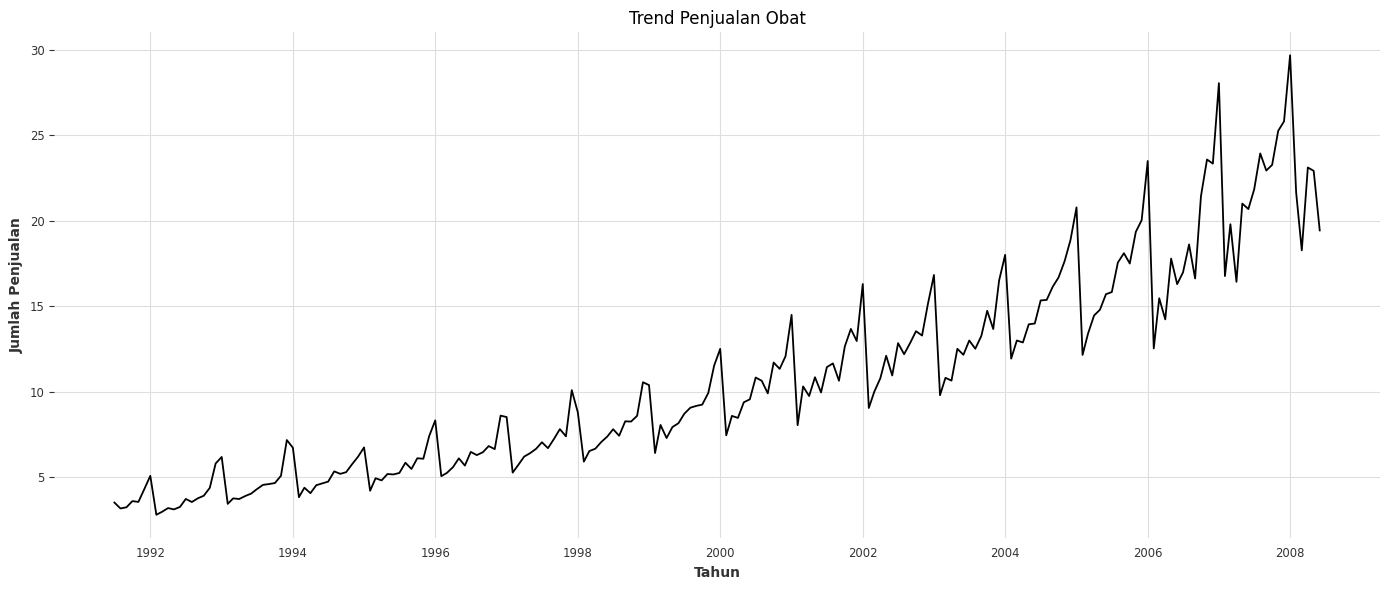

In [ ]:
# Plot trend
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['value'])
plt.title('Trend Penjualan Obat')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Penjualan')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Insight :

Grafik menunjukkan tren positif yang jelas, dimana penjualan obat meningkat secara konsisten di awal tahun 1990-an hingga tahun 2008 yang menandakan pertumbuhan permintaan berkelanjutan. Selain itu, adanya pola musiman yang berulang tiap tahun. Selain tren dan musiman, grafik memperlihatkan bahwa varians meningkat seiring waktu, dimana perbedaan puncak dan lembah penjualan setiap tahunnya makin melebar. Dengan demikian, karakteristik ini menjadikan data bersifat non-stationer, sehingga memerlukan preprocessing lebih lanjut.

## Cek Seasonality

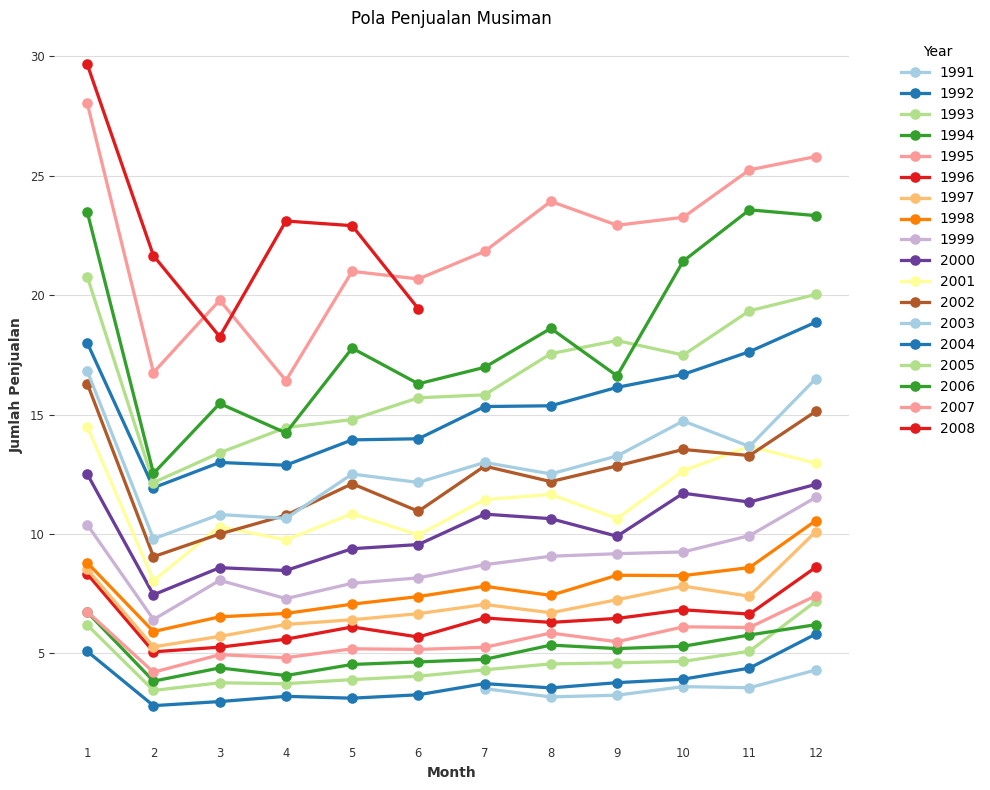

In [ ]:
df_temp = df.copy()

# Ekstrak Tahun dan Bulan
df_temp['Year'] = pd.DatetimeIndex(df_temp.index).year
df_temp['Month'] = pd.DatetimeIndex(df_temp.index).month

# Plot Seasonality
plt.figure(figsize=(10, 8))
plt.title('Pola Penjualan Musiman')
sns.pointplot(x='Month', y='value', hue='Year', data=df_temp, palette='Paired')
plt.xlabel('Month')
plt.ylabel('Jumlah Penjualan')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Insight :

Grafik tersebut menunjukkan pola musiman yang berulang setiap tahun, dimana penjualan obat cenderung menurun di awal tahun dan perlahan-lahan meningkat hingga mencapai puncak di akhir tahun. Selain itu, terlihat adanya tren positif dari waktu ke waktu disertai tiap tahun memiliki level penjualan lebih tinggi dibandingkan tahun sebelumnya. Varians juga tidak konstan. Dengan demikian, dapat dikatakan bahwa data ini bersifat non-stationer sehingga memerlukan preprocessing lebih lanjut.

### Cek periode seasonality

In [ ]:
df_ts = df.reset_index()
df_ts

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510


In [ ]:
from darts import TimeSeries
ts = TimeSeries.from_dataframe(df_ts, time_col = 'date', value_cols = 'value')
series = ts #buat backup

In [ ]:
for m in range(2, 50):
    is_seasonal, mseas = check_seasonality(ts, m=m, alpha=ALPHA)
    if is_seasonal == True:
        print('Seasonality Detected! Seasonal period = ', m)
        break

Seasonality Detected! Seasonal period =  10


## Cek Multiplikative or additive

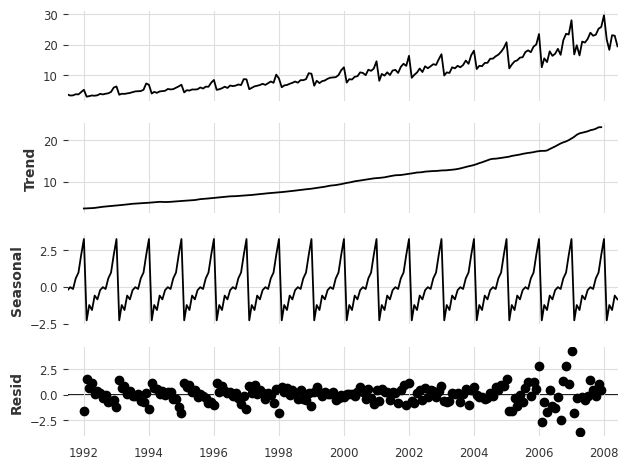

In [ ]:
df_additive = sm.tsa.seasonal_decompose(df, model='additive')
fig = df_additive.plot()

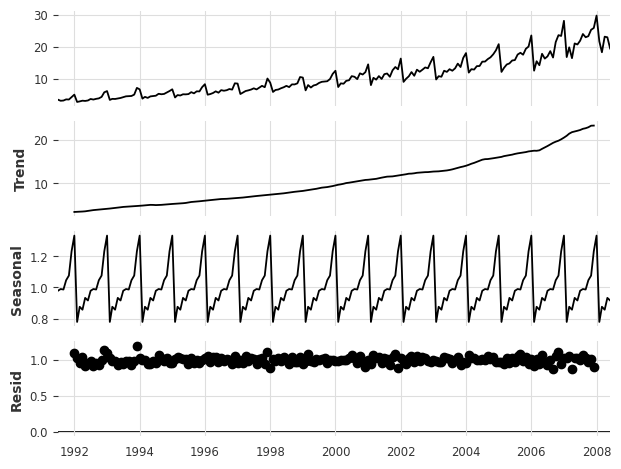

In [ ]:
df_multiplicative = sm.tsa.seasonal_decompose(df, model='multiplicative')
fig = df_multiplicative.plot()

Insight :

Dataset ini menunjukkan pola multiplikative, dapat dilihat pada plot residualnya berbentuk pola horizontal. Selain itu, pada plot tren, varians meningkat seiring waktu, menandakan bahwa variabilitas musiman meningkat seiring dengan naiknya tren yang sedang berlangsung.

## Cek Data Stationery

In [ ]:
def stationarity_test(timeseries):
    # Get rolling statistics for window = 12 i.e. yearly statistics
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()

    # Plot rolling statistic -> Kualitatif
    plt.figure(figsize= (10,6))
    plt.xlabel('Years')
    plt.ylabel('Jumlah Penjualan')
    plt.title('Stationary Test: Rolling Mean and Standard Deviation')
    plt.plot(timeseries, color= 'blue', label= 'Original')
    plt.plot(rolling_mean, color= 'green', label= 'Rolling Mean')
    plt.plot(rolling_std, color= 'red', label= 'Rolling Std')
    plt.legend()
    plt.show()

    # Dickey-Fuller test -> Kuantitatif
    print('Results of Dickey-Fuller Test')
    df_test = adfuller(timeseries)
    # print(df_test)
    df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' %key] = value
    print(df_output)

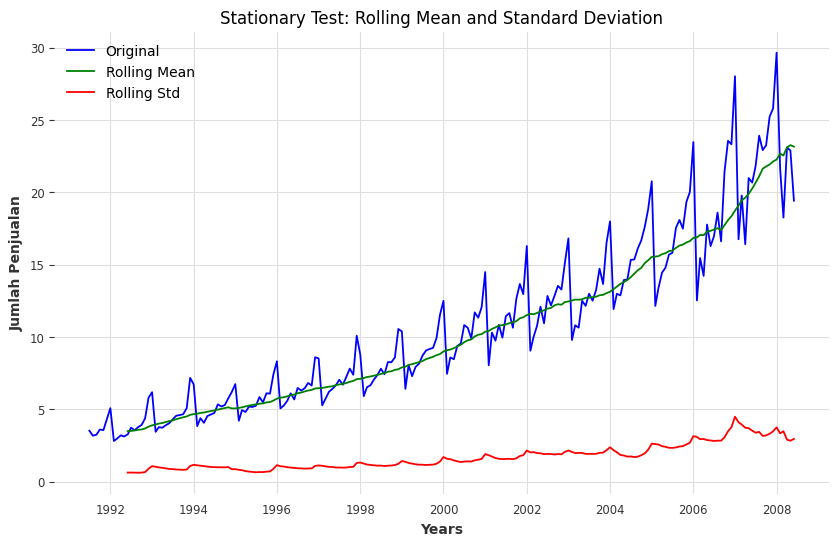

Results of Dickey-Fuller Test
Test Statistic                   3.145186
p-value                          1.000000
#Lags Used                      15.000000
Number of Observations Used    188.000000
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
Critical Value (10%)            -2.575032
dtype: float64


In [ ]:
stationarity_test(df)

Insight :

1. Data tidak stationer, hal ini dibuktikan di p value > 0.05
2. Nilai test statistic lebih besar dibandingkan semua nilai pada critical value, menunjukkan bahwa uji Dickey-Fuller gagal menolak H0 (Data tidak stasioner)

# Preprocessing Data

## Differencing

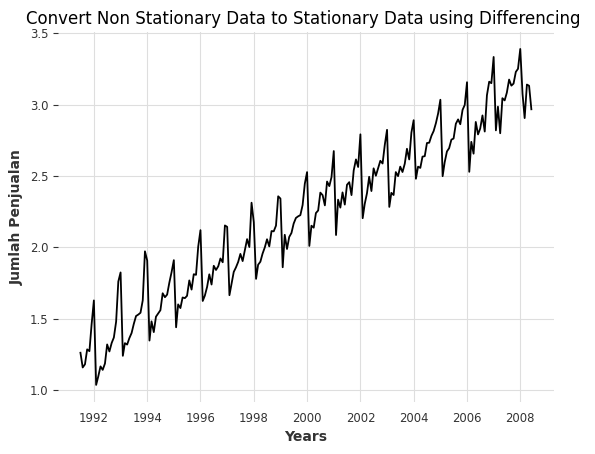

In [ ]:
df_log = np.log(df)

df_diff_log = df_log.diff(periods = 2)
plt.xlabel('Years')
plt.ylabel('Jumlah Penjualan')
plt.title('Convert Non Stationary Data to Stationary Data using Differencing ')
plt.plot(df_log)

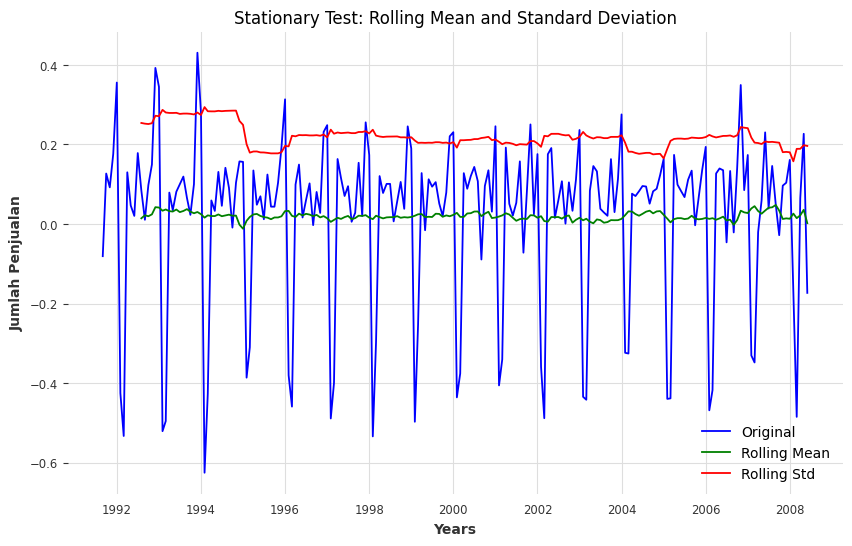

Results of Dickey-Fuller Test
Test Statistic                  -3.799575
p-value                          0.002912
#Lags Used                      14.000000
Number of Observations Used    187.000000
Critical Value (1%)             -3.465812
Critical Value (5%)             -2.877123
Critical Value (10%)            -2.575077
dtype: float64


In [ ]:
df_diff_log.dropna(inplace = True)
stationarity_test(df_diff_log)

Insight :

1. Berdasarkan grafik "Stationary Test", data deret waktu yang sudah di-differencing (garis biru) menunjukkan bahwa tren dan musiman telah berhasil dihilangkan. Hal ini ditunjukkan oleh (rolling mean) yang konstan dan mendekati nol (garis hijau), serta (rolling standard deviation) yang stabil (garis merah), meskipun ada sedikit fluktuasi. Secara visual, ini mengonfirmasi bahwa data sudah memenuhi syarat stationer, yaitu rata-rata dan varians yang konstan.

2. Hasil uji Dickey-Fuller secara statistik juga mendukung kesimpulan tersebut. Nilai Test Statistic (-3.799575) lebih kecil dari semua Critical Value pada tingkat 1%, 5%, dan 10%. Selain itu, p-value (0.002912) yang jauh di bawah ambang batas 0.05 memungkinkan kita untuk menolak hipotesis nol, yang menyatakan bahwa data tidak stasioner. Dengan demikian, kedua hasil, baik visual maupun statistik, secara konsisten membuktikan bahwa data Anda telah berhasil menjadi stasioner dan siap untuk pemodelan forecasting.

## Log Transformation

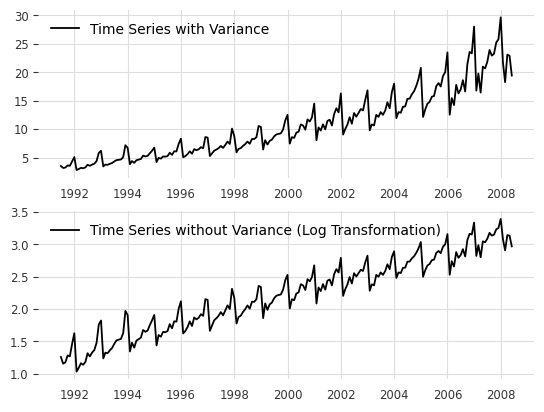

In [ ]:
df_log = np.log(df)

plt.subplot(211)
plt.plot(df, label= 'Time Series with Variance')
plt.legend()
plt.subplot(212)
plt.plot(df_log, label='Time Series without Variance (Log Transformation)')
plt.legend()
plt.show()

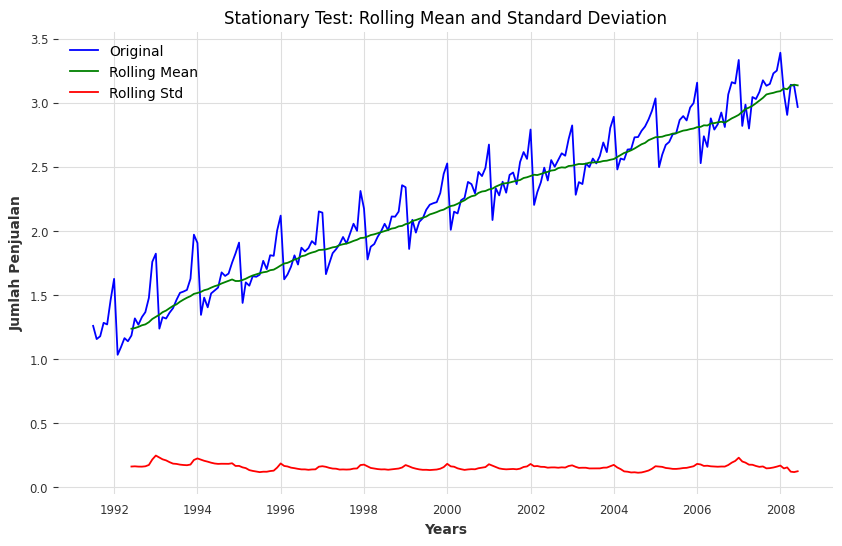

Results of Dickey-Fuller Test
Test Statistic                  -0.988733
p-value                          0.757351
#Lags Used                      14.000000
Number of Observations Used    189.000000
Critical Value (1%)             -3.465431
Critical Value (5%)             -2.876957
Critical Value (10%)            -2.574988
dtype: float64


In [ ]:
stationarity_test(df_log)

Insight :

1. Berdasarkan grafik "Stationary Test", menunjukkan bahwa data tidak stasioner. Garis biru (Original) dan hijau (Rolling Mean) menunjukkan tren naik yang jelas, artinya rata-rata data tidak konstan seiring waktu. Meskipun garis merah (Rolling Std) terlihat relatif stabil, adanya tren pada rata-rata sudah cukup untuk menyimpulkan bahwa data ini tidak stasioner.
2. Hasil uji Dickey-Fuller secara statistik juga mengonfirmasi bahwa data tidak stasioner. Nilai Test Statistic (-0.988733) lebih besar dari semua Critical Value , dan p-value (0.757351) jauh lebih besar dari ambang batas 0.05. Ini berarti kita **gagal** menolak hipotesis nol, yang menyatakan bahwa data tidak stasioner. Oleh karena itu, data ini perlu melalui proses preprocessing seperti differencing combination pada metode moving average.

## Moving Average

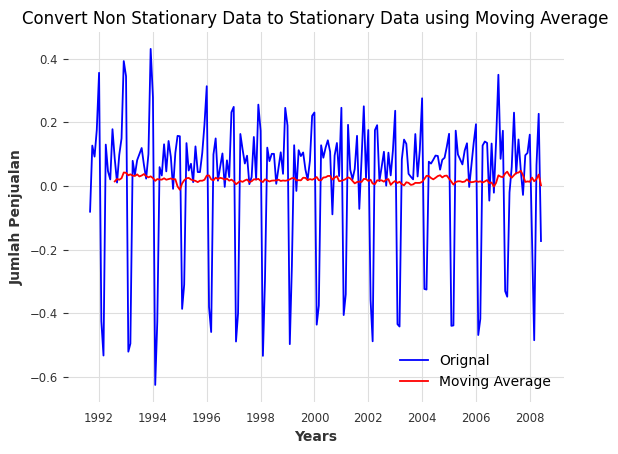

In [ ]:
df_log_moving_avg = df_diff_log.rolling(window = 12).mean()
plt.xlabel('Years')
plt.ylabel('Jumlah Penjualan')
plt.title('Convert Non Stationary Data to Stationary Data using Moving Average')
plt.plot(df_diff_log, color= 'blue', label='Orignal')
plt.plot(df_log_moving_avg, color= 'red', label='Moving Average')
plt.legend()
plt.show()

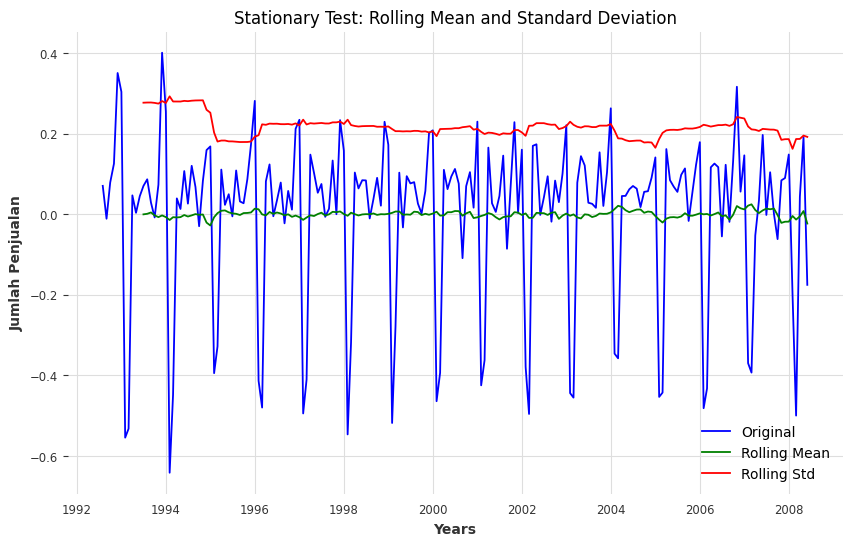

Results of Dickey-Fuller Test
Test Statistic                  -4.090266
p-value                          0.001005
#Lags Used                      14.000000
Number of Observations Used    176.000000
Critical Value (1%)             -3.468062
Critical Value (5%)             -2.878106
Critical Value (10%)            -2.575602
dtype: float64


In [ ]:
df_log_moving_avg_diff = df_diff_log - df_log_moving_avg
df_log_moving_avg_diff.dropna(inplace = True)
stationarity_test(df_log_moving_avg_diff)

Insight :

1. Berdasarkan grafik "Stationary Test", data original (garis biru) menunjukkan rolling mean (garis hijau) yang stabil di sekitar nol, mengindikasikan bahwa tren telah berhasil dihilangkan. Begitu juga dengan rolling standar deviasi (garis merah) yang konstan. Secara visual, grafik ini memperlihatkan bahwa data ini telah memenuhi kriteria stasioner, yaitu rata-rata dan varians yang konstan dari waktu ke waktu.

2. Hasil uji Dickey-Fuller secara statistik juga mendukung kesimpulan tersebut. Nilai Test Statistic (-4.090266) lebih kecil dari Critical Value pada tingkat 1%, 5%, dan 10%, yang memungkinkan kita untuk menolak hipotesis nol (bahwa data tidak stasioner). Selain itu, p-value (0.001005) yang sangat kecil (jauh di bawah 0.05) memberikan bukti kuat bahwa data ini sudah stasioner. Oleh karena itu, data ini sudah siap untuk digunakan dalam pemodelan forecasting lebih lanjut.

# Forecasting

In [ ]:
df_log_moving_avg_diff

,value
date,
1992-08-01,0.070264
1992-09-01,-0.011352
1992-10-01,0.078412
1992-11-01,0.125357
1992-12-01,0.350213
...,...
2008-02-01,-0.201439
2008-03-01,-0.499633
2008-04-01,0.043221


In [ ]:
df_ts = df_log_moving_avg_diff.reset_index()
df_ts

,date,value
0,1992-08-01,0.070264
1,1992-09-01,-0.011352
2,1992-10-01,0.078412
3,1992-11-01,0.125357
4,1992-12-01,0.350213
...,...,...
186,2008-02-01,-0.201439
187,2008-03-01,-0.499633
188,2008-04-01,0.043221
189,2008-05-01,0.191004


In [ ]:
ts = TimeSeries.from_dataframe(df_ts, time_col = 'date', value_cols = 'value')
series = ts #buat backup

<Axes: xlabel='date'>

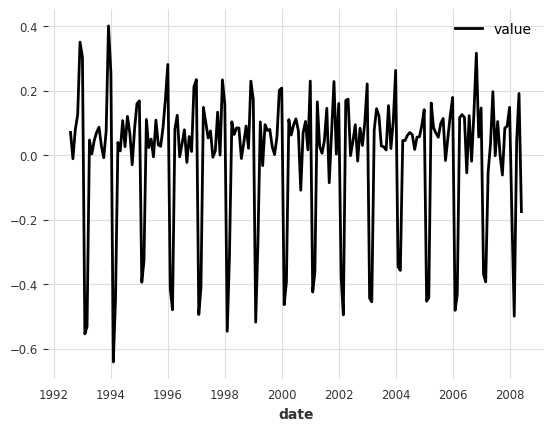

In [ ]:
ts.plot()

<Axes: xlabel='date'>

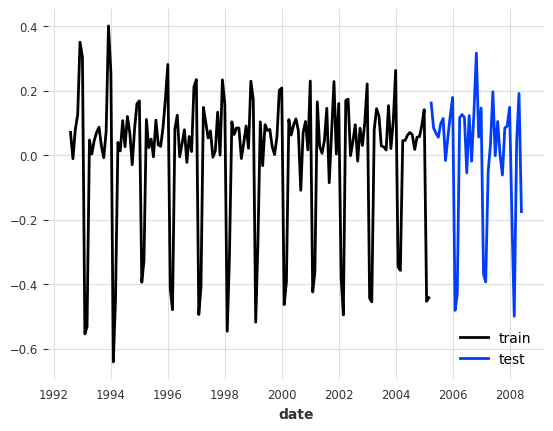

In [ ]:
# Splitting
ts_train, ts_test = ts.split_before(0.80)
ts_train.plot(label = 'train')
ts_test.plot(label = 'test')

In [ ]:
#function bernama evaluate untuk mengevaluasi prediksi dibanding data actual
def evaluate(actual_test, prediction):
    print(f'RMSE: {rmse(actual_test, prediction)}')

RMSE: 0.19403502998177036
Fitting the time series model takes 0.6347482204437256 seconds.


<Axes: xlabel='date'>

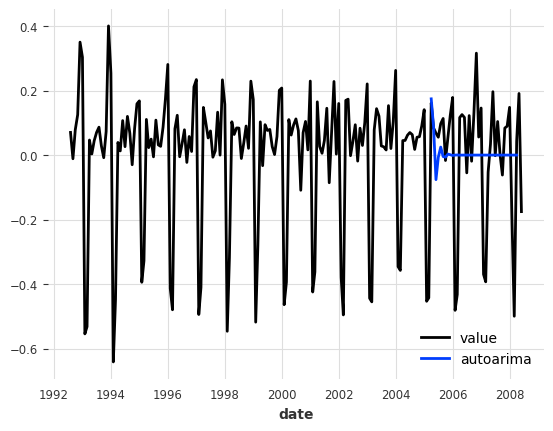

In [ ]:
autoarima = AutoARIMA() #settingan default
start = time.time()
autoarima.fit(ts_train) # fit ini adalah proses training
end = time.time()
autoarima_forecast = autoarima.predict(37) #angka 37 merupakan 25% data dari 144 baris

#evaluasi menggunakan evaluate
evaluate(ts_test, autoarima_forecast)

print('Fitting the time series model takes', end - start, 'seconds.')
series.plot()
autoarima_forecast.plot(label = 'autoarima')

In [ ]:
new_autoarima = AutoARIMA(d=0, # data sudah di-differencing, jadi tidak perlu lagi
                          D=0, # data sudah di-differencing, jadi tidak perlu lagi
                          seasonal=False, # Karena sudah mengatasi seasonality dengan moving average
                          stationary=True
                          )

historical forecasts: 100%|██████████| 142/142 [01:13<00:00,  1.92it/s]


Evaluasi Forecast 
RMSE: 0.16511738755570937


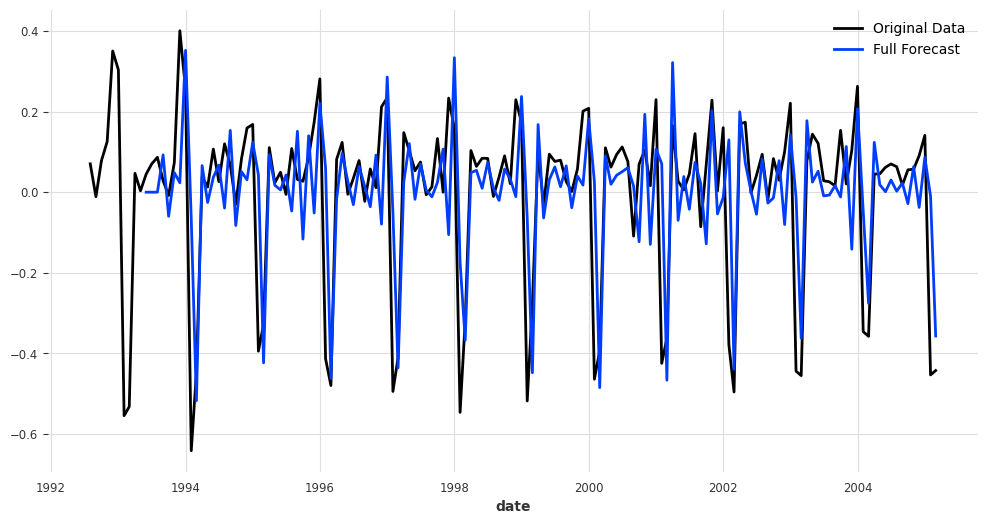

In [ ]:
# Prediksi in-sample untuk data train
train_forecast = new_autoarima.historical_forecasts(
    ts_train,
    start=0,
    forecast_horizon=1,
    verbose=True
)

# 4. Evaluasi Prediksi Full Data
print("Evaluasi Forecast ")
evaluate(ts_train, train_forecast)

# 5. Plot Full Forecast
plt.figure(figsize=(12, 6))
ts_train.plot(label='Original Data')
train_forecast.plot(label='Full Forecast')
plt.legend()
plt.show()

Insight :

 Model AutoARIMA telah berhasil memprediksi data dengan akurat. Grafik "Original Data" dan "Full Forecast" menunjukkan bahwa garis prediksi (biru) secara ketat mengikuti pola data asli (hitam), termasuk fluktuasi naik-turun yang kompleks. Korelasi ini diperkuat oleh nilai RMSE (Root Mean Squared Error) sebesar 0.1651. Angka ini menunjukkan rata-rata kesalahan prediksi model autoARIMA adalah sekitar 0.1651. Berdasarkan skala asli pada data original antara 2.8 hingga 29.6, RMSE 0.1651 merupakan nilai yang sangat rendah, membuktikan bahwa model ini memiliki akurasi baik dalam forecasting time series ini.

In [ ]:
new_autoarima.fit(ts_train) # Fit the model to the training data
prediksi_di_masa_depan = new_autoarima.predict(10)
prediksi_di_masa_depan

<TimeSeries (date: 10, component: 1, sample: 1)> Size: 80B
array([[[ 0.17437822]],

       [[ 0.08818799]],

       [[-0.07613419]],

       [[-0.00665728]],

       [[ 0.02484045]],

       [[-0.00453365]],

       [[-0.00633597]],

       [[ 0.00304588]],

       [[ 0.0011177 ]],

       [[-0.00121835]]])
Coordinates:
  * date       (date) datetime64[ns] 80B 2005-04-01 2005-05-01 ... 2006-01-01
  * component  (component) object 8B 'value'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

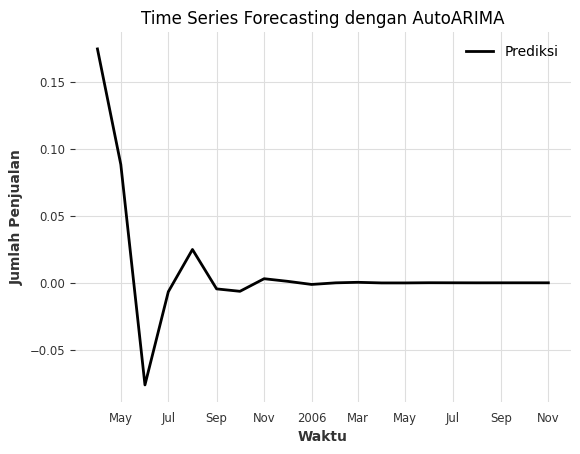

In [ ]:
# Fit the model to the training data
new_autoarima.fit(ts_train)

# prediksi
prediksi_di_masa_depan = new_autoarima.predict(20)

# plot prediksi
prediksi_di_masa_depan.plot(label="Prediksi")

plt.title("Time Series Forecasting dengan AutoARIMA")
plt.xlabel("Waktu")
plt.ylabel("Jumlah Penjualan")
plt.legend()
plt.show()